In [5]:
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import preprocessing as tfkp
from tensorflow.keras.datasets import imdb
from tensorflow.keras import layers as l
import numpy as np
import matplotlib.pyplot as plt
import os

In [9]:
def show_res():
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, acc, 'bo', label='Точность тренировки')
    plt.plot(epochs, val_acc, 'b', label='Точность проверки')
    plt.title('Точность тренировки и проверки')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'ro', label='Потери тренировки')
    plt.plot(epochs, val_loss, 'r', label='Потери проверки')
    plt.title('Потери тренировки и проверки')
    plt.legend()

    plt.show()

In [6]:
max_features = 10000
max_len = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print(len(x_train), '- длина последовательности тренировки')
print(len(x_test), '- длина последовательности тестирования')

print('Pad sequences (примеры х время)')
x_train = tfkp.sequence.pad_sequences(x_train, maxlen=max_len)
x_test = tfkp.sequence.pad_sequences(x_test, maxlen=max_len)

print('Форма последовательности тренировки:', x_train.shape)
print('Форма последовательности тестирования:', x_test.shape)

17464789/17464789 [==============================] - 1s 0us/step
25000 - длина последовательности тренировки
25000 - длина последовательности тестирования
Pad sequences (примеры х время)
Форма последовательности тренировки: (25000, 500)
Форма последовательности тестирования: (25000, 500)


In [8]:
model = tfk.models.Sequential([
    l.Embedding(max_features, 128, input_length=max_len),
    l.Conv1D(32, 7, activation='relu'),
    l.MaxPooling1D(5),
    l.Conv1D(32, 7, activation='relu'),
    l.GlobalMaxPooling1D(),
    l.Dense(1)
])

model.compile(optimizer=tfk.optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 40s 188ms/step - loss: 0.6163 - acc: 0.7048 - val_loss: 0.4086 - val_acc: 0.8398
Epoch 2/10
157/157 [==============================] - 17s 108ms/step - loss: 0.3968 - acc: 0.8678 - val_loss: 0.5595 - val_acc: 0.8076
Epoch 3/10
157/157 [==============================] - 13s 82ms/step - loss: 0.3175 - acc: 0.9068 - val_loss: 0.6364 - val_acc: 0.8320
Epoch 4/10
157/157 [==============================] - 12s 75ms/step - loss: 0.2657 - acc: 0.9316 - val_loss: 0.5199 - val_acc: 0.8734
Epoch 5/10
157/157 [==============================] - 7s 47ms/step - loss: 0.2011 - acc: 0.9560 - val_loss: 1.0932 - val_acc: 0.8254
Epoch 6/10
157/157 [==============================] - 8s 49ms/step - loss: 0.1608 - acc: 0.9738 - val_loss: 0.9611 - val_acc: 0.8556
Epoch 7/10
157/157 [==============================] - 7s 44ms/step - loss: 0.1310 - acc: 0.9840 - val_loss: 0.8281 - val_acc: 0.8710
Epoch 8/10
157/157 [==============================] - 6s 38ms/s

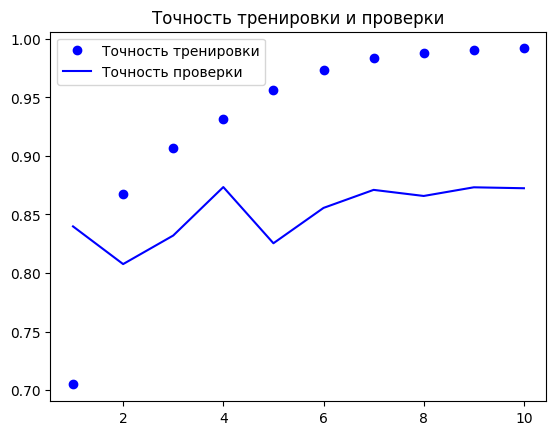

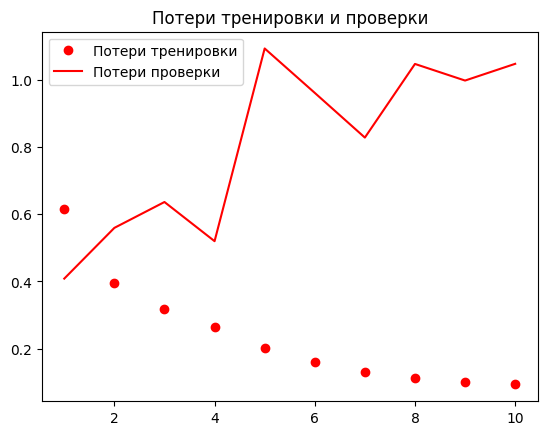

In [10]:
show_res()

In [11]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Colab Notebooks/Datasets/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(",")
lines = lines[1:]

print(header)
print(len(lines))

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    """Функция-генератор данных.
    :data - исходный массив нормализованных вещественных чисел.
    :lookback - количество интервалов в прошлом от заданного момента.
    :delay - количество интервалов в будущем от заданного момента.
    :min_index - индекс в массиве data, ограничивающие область для извлечения данных.
    :max_index - индекс в массиве data, ограничивающие область для извлечения данных.
    :shuffle - флаг, определящий порядок извлечения образцов (с перемешиванием или в хронологическом порядке).
    :batch_size - количество образцов в пакете.
    :step - период в интервалах, из которого извлекается один образец; базово равен 6, чтобы было в 1 образцу в час"""
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Mounted at /content/drive
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [12]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [13]:
model = tfk.models.Sequential([
    l.Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])),
    l.MaxPooling1D(3),
    l.Conv1D(32, 5, activation='relu'),
    l.GRU(32, dropout=0.1, recurrent_dropout=0.5),
    l.Dense(1)
])

model.summary()

model.compile(optimizer=tfk.optimizers.RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)


def show_res2():
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, 'ro', label='Потери тренировки')
    plt.plot(epochs, val_loss, 'r', label='Потери проверки')
    plt.title('Потери тренировки и проверки')
    plt.legend()

    plt.show()

show_res2()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 32)          2272      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, None, 32)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, None, 32)          5152      
                                                                 
 gru (GRU)                   (None, 32)                6336      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
__________________________________________________

KeyboardInterrupt: ignored